## IN PROGRESS

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from task1_profanity.regex_detector import ProfanityRegexDetector
from task1_profanity.llm_detector import ProfanityLLMDetector

d:\prodigal\prodig\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_conversations(folder_path):
    data = []
    for fname in os.listdir(folder_path):
        if fname.endswith('.json'):
            fpath = os.path.join(folder_path, fname)
            try:
                with open(fpath, 'r') as f:
                    convo = json.load(f)
                    data.append((fname, convo))
            except Exception as e:
                print(f"[ERROR] Failed to load {fname}: {e}")
    return data

In [3]:
def basic_eda(conversations):
    total_conversations = len(conversations)
    speakers = Counter()
    texts = []

    for _, convo in conversations:
        for c in convo:
            speakers[c.get("speaker", "unknown").lower()] += 1
            texts.append(c.get("text", ""))

    avg_len = sum(len(t.split()) for t in texts) / len(texts) if texts else 0
    print(f"Total conversations: {total_conversations}")
    print(f"Speaker distribution: {speakers}")
    print(f"Average utterance length: {avg_len:.2f} words")


In [8]:
def compare_detectors(conversations, llm_detector, regex_detector):
    results = []
    counter = 20
    for fname, convo in conversations:
        llm_flags = llm_detector.analyze_conversation(convo)
        regex_flags = regex_detector.analyze_conversation(convo)

        results.append({
            "file": fname,
            "llm_agent": llm_flags["agent_profanity"],
            "llm_borrower": llm_flags["borrower_profanity"],
            "regex_agent": regex_flags["agent_profanity"],
            "regex_borrower": regex_flags["borrower_profanity"],
            "agent_match": llm_flags["agent_profanity"] == regex_flags["agent_profanity"],
            "borrower_match": llm_flags["borrower_profanity"] == regex_flags["borrower_profanity"]
        })
        counter -= 1
        if counter <= 0:
            break

    df = pd.DataFrame(results)
    return df

In [5]:
def plot_comparison_stats(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(14, 6))

    # Match summary
    match_counts = pd.DataFrame({
        "Speaker": ["Agent", "Borrower"],
        "Match": [df["agent_match"].sum(), df["borrower_match"].sum()],
        "Mismatch": [len(df) - df["agent_match"].sum(), len(df) - df["borrower_match"].sum()]
    })

    match_counts_melted = match_counts.melt(id_vars="Speaker", var_name="Type", value_name="Count")
    plt.subplot(1, 2, 1)
    sns.barplot(data=match_counts_melted, x="Speaker", y="Count", hue="Type")
    plt.title("Match vs Mismatch per Speaker")

    # Profanity detection rate
    detection = pd.DataFrame({
        "Speaker": ["Agent", "Borrower"],
        "LLM": [
            df["llm_agent"].sum(),
            df["llm_borrower"].sum()
        ],
        "Regex": [
            df["regex_agent"].sum(),
            df["regex_borrower"].sum()
        ]
    }).melt(id_vars="Speaker", var_name="Method", value_name="Count")

    plt.subplot(1, 2, 2)
    sns.barplot(data=detection, x="Speaker", y="Count", hue="Method")
    plt.title("Profanity Detected by Method")

    plt.tight_layout()
    plt.show()


def plot_confusion_heatmap(df):
    conf_df = pd.DataFrame({
        "LLM Agent": df["llm_agent"].astype(str),
        "Regex Agent": df["regex_agent"].astype(str)
    })

    heatmap_data = pd.crosstab(conf_df["LLM Agent"], conf_df["Regex Agent"])
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues")
    plt.title("Agent Profanity Detection Confusion (LLM vs Regex)")
    plt.xlabel("Regex")
    plt.ylabel("LLM")
    plt.show()


=== Loading Conversations ===

=== Performing Basic EDA ===
Total conversations: 250
Speaker distribution: Counter({'agent': 1666, 'customer': 1521})
Average utterance length: 11.77 words

=== Initializing Detectors ===

=== Running Comparison ===
[ERROR] Gemini LLM failed: Extra data: line 5 column 1 (char 62)
[ERROR] Gemini LLM failed: Extra data: line 5 column 1 (char 62)
[ERROR] Gemini LLM failed: Expecting value: line 1 column 1 (char 0)
[ERROR] Gemini LLM failed: Extra data: line 5 column 1 (char 62)
[ERROR] Gemini LLM failed: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
  

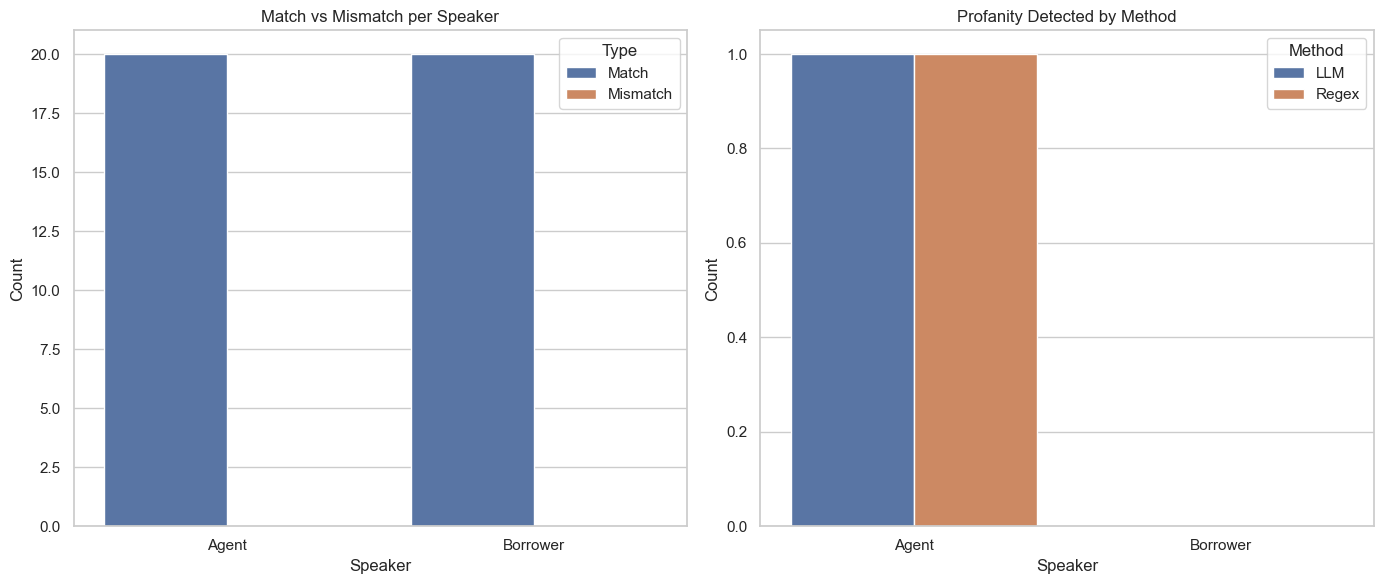

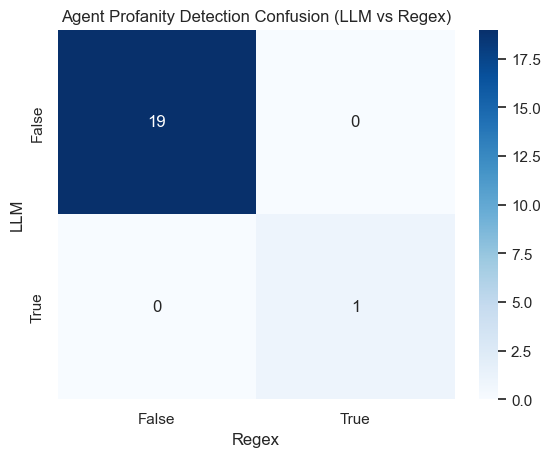

In [ ]:

if __name__ == "__main__":
    folder_path = "All_Conversations"

    print("=== Loading Conversations ===")
    conversations = load_conversations(folder_path)

    print("\n=== Performing Basic EDA ===")
    basic_eda(conversations)

    print("\n=== Initializing Detectors ===")
    llm_detector = ProfanityLLMDetector(api_key=API_KEY)
    regex_detector = ProfanityRegexDetector()

    print("\n=== Running Comparison ===")
    df_results = compare_detectors(conversations, llm_detector, regex_detector)

    df_results.to_csv("profanity_comparison.csv", index=False)

    print("\n=== Generating Visuals ===")
    plot_comparison_stats(df_results)
    plot_confusion_heatmap(df_results)
